# Exercises

## Imports

In [1]:
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
import seaborn as sns
import pickle
import numpy as np
from scipy.stats import zscore
import sys
import timeit
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf
from scipy.fft import fft, fftfreq
from ipywidgets import interact
import ipywidgets as widgets
from pywt import scale2frequency
from pywt import cwt

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle`
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Try and fix a central frequency and play with the width of the band, then try to change the central frequency of the band.
- Try to change the order of the filter, for a fixed frequency band. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic commeand [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [2]:
sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})


In [3]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


Text(0, 0.5, 'voltage (mV)')

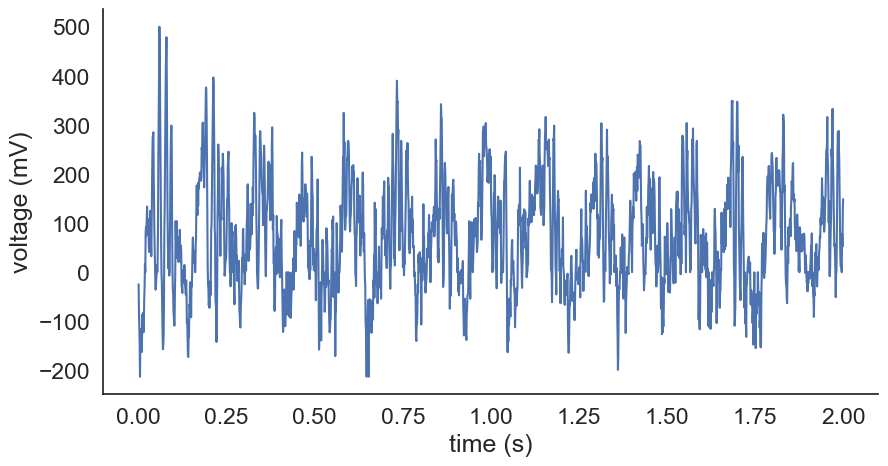

In [4]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

# Visualising a few seconds of the data
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,2,2000),lfp[:2000])
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

In [5]:
# Define filter object
filter_order = 5
low_f = 1
high_f = 200

filter = butter(filter_order,[low_f,high_f],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

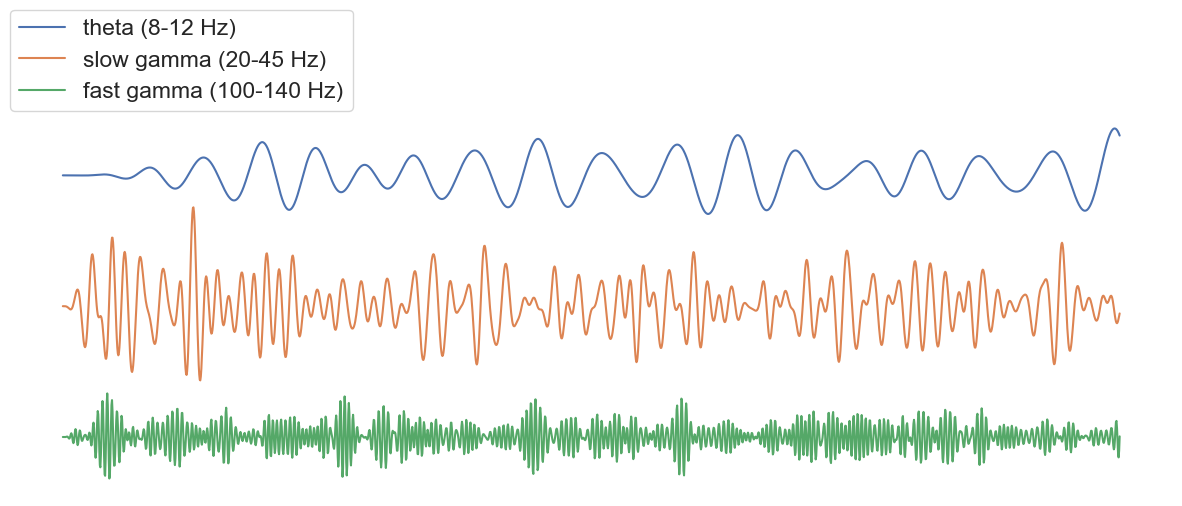

In [6]:
# Filtering the data in different frequency bands
theta_lfp = lf.bandpass_filter(lfp, low_f=8, high_f=12, sampling_rate=sampling_rate)
slow_gamma_lfp = lf.bandpass_filter(lfp, low_f=20, high_f=45, sampling_rate=sampling_rate)
fast_gamma_lfp = lf.bandpass_filter(lfp, low_f=100,high_f=140, sampling_rate=sampling_rate)

plot_offset = 200 #to plot the signal on different lines

plt.figure(figsize=(15,5))
plt.plot(theta_lfp[:2000]+2*plot_offset,label='theta (8-12 Hz)')
plt.plot(slow_gamma_lfp[:2000]+plot_offset,label = 'slow gamma (20-45 Hz)')
plt.plot(fast_gamma_lfp[:2000],label = 'fast gamma (100-140 Hz)')

plt.axis('off')
plt.legend(loc=(0,1))

In [7]:
# Create widget to play with all the values

def different_widths(freq, width, filter_order):
    plt.figure(figsize=(10,5))
    filter_order = filter_order
    filter = lf.bandpass_filter(lfp, low_f = max(freq-(0.5*width), 1),
                                high_f = min(freq+(0.5*width), 100),
                                sampling_rate=sampling_rate,
                                filter_order = filter_order)
    plt.plot(filter[:2000]+2*plot_offset, label = 'Filtered Wave')
    plt.legend(loc=[1,1])
    plt.axis('off')

interact(different_widths, width = widgets.FloatSlider(min=1, max=200, value=4),
                        freq = widgets.FloatSlider(min=1, max=100, value=10),
                        filter_order =  widgets.IntSlider(min = 1, max = 5, value = 5))

interactive(children=(FloatSlider(value=10.0, description='freq', min=1.0), FloatSlider(value=4.0, description…

<function __main__.different_widths(freq, width, filter_order)>

In [8]:
for filter_order in np.arange(1, 6, 1):
        print("Filter Order:", filter_order)
        %timeit theta_lfp = lf.bandpass_filter(lfp, low_f=8, high_f=12, sampling_rate=sampling_rate, filter_order=filter_order)

Filter Order: 1
5.34 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Filter Order: 2
5.43 ms ± 99.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Filter Order: 3
5.86 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Filter Order: 4
7.2 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Filter Order: 5
8.32 ms ± 59.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


If we fix the central frequency (I set it to 30), and fix the filter width we see that the amount of wavelets increase. At first they are quite easy to count and are spatially isolated. As we increase the width the signal becomes messier as it is obvious that more different frequencies impact the plot. At maximum width the signal turns into the first plot (we created to simply visualize the data.)

If we set the width to a fixed value  (I set it to ~10) and we change the central frequency. We see that the period of the signal decreases while the amount of wavelets, who start to take shape from around f ~20, stays relatively constant. Thus we see the opposite happening as before.

The above was done with filter_order = 5. When we change the order of the filter we see that the signal becomes messier with a lower order. Which makes sense since we filter out less frequencies. Lowering the order thus has a similar effect to increasing the filter width. 

Note that the specific numbers and percentages differ from run to run. The following was written after a different run than what is now seen above.
The computing time changes about 25% from a filtering_order 1 to 5. Which is quite significant, however it still takes only a couple of milliseconds so the increase is not noticable at all. The standard deviations per order differ quite a bit (by a factor 5) which is quite surprising to me.  Overall there is an increase of ~.25ms per order.

### FPB comments 
Code is very well written. Indeed the comparison between orders reveals that the cutoffs in frequenct response become blurrier with lower order filters, which makes the filtered signals "messier" (i.e. containing more frequencies)

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). this are all real wavelet.
- How does the spectrum look different from what we computed with a complex Morlet tranform ? Comment on why do you think this might be the case.

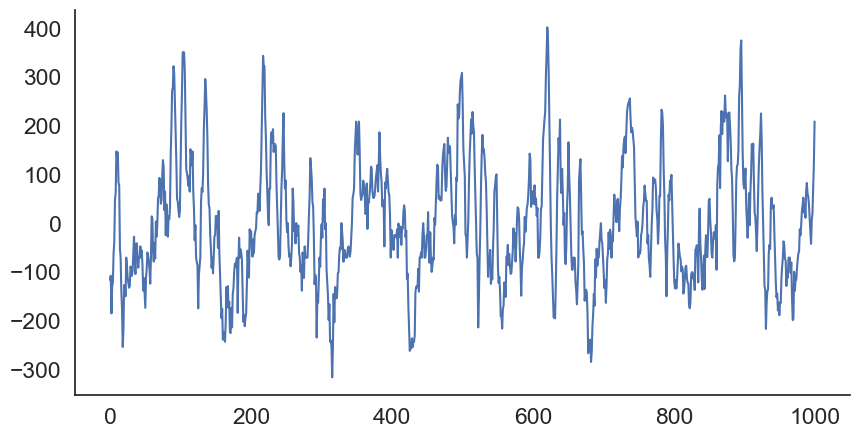

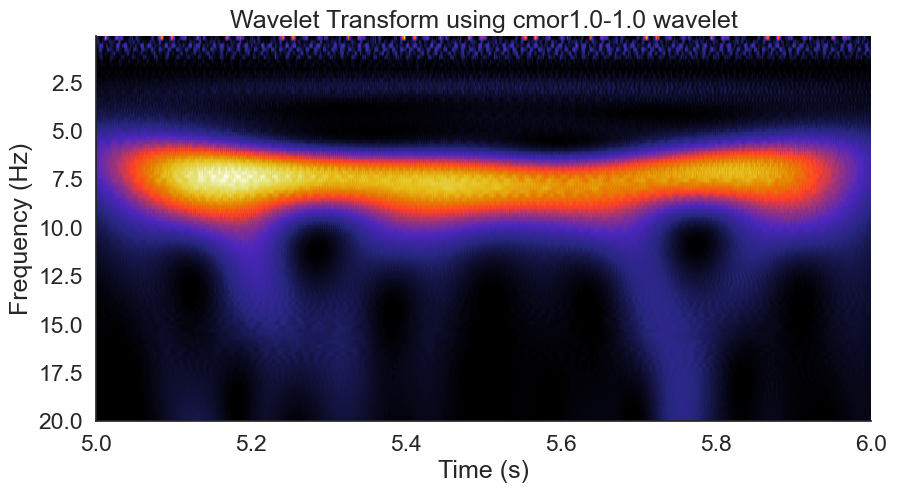

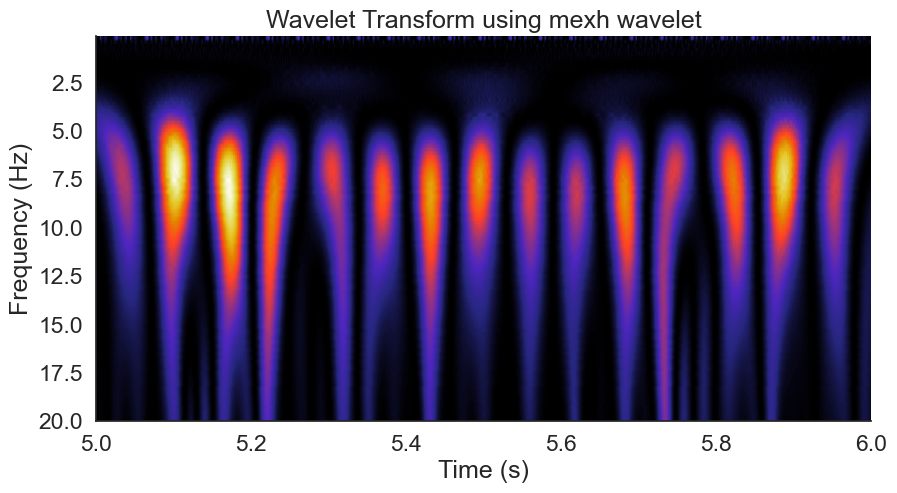

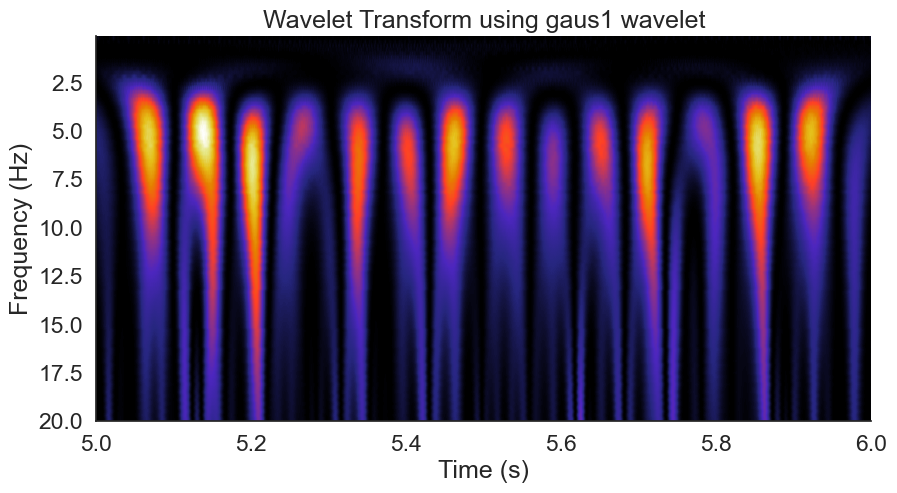

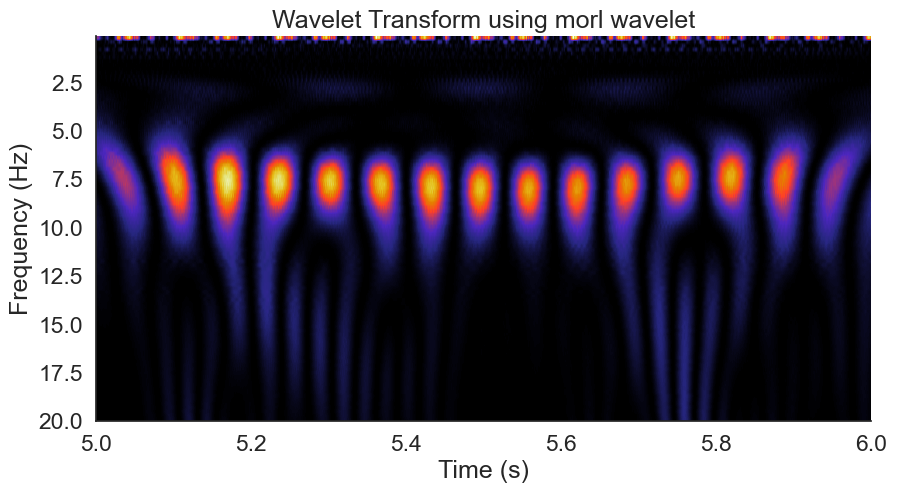

In [9]:
start = 5  # in seconds
end = 6  # in seconds

sig = lfp[int(start * sampling_rate):int(end * sampling_rate)]
sig = sig - np.mean(sig)  # get rid of 0 frequency component

plt.figure(figsize=(10, 5))
plt.plot(sig)

frequencies = np.linspace(0.1, 20, 100) / sampling_rate
wavelets = ['cmor1.0-1.0', 'mexh', 'gaus1', 'morl']

for wavelet_name in wavelets:
    scales = scale2frequency(wavelet_name, frequencies)
    cwtmatr, _ = cwt(sig, wavelet=wavelet_name, scales=scales,
                     sampling_period=1.0 / sampling_rate)

    plt.figure(figsize=(10, 5))
    plt.imshow(abs(cwtmatr) ** 2, extent=[start, end, frequencies[-1] * sampling_rate,
                                        frequencies[0] * sampling_rate], aspect='auto', cmap='CMRmap')
    plt.title(f'Wavelet Transform using {wavelet_name} wavelet')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

We see a few notable differences, most striking is the dissapearance of the continiuity of the signal at ~7.5 Hz. In the real morlet spectrogram we see very distinct blobs instead of a long stripe. In the case of the mexican hat or gaussian wavelets the blobs turn more reverse tear-like shapes as if they slowly slide up. This change was to be expected since the real wavelets contain less information than the complex counterpart: the phase shift information is not contained. We therefore lose information and get a less accurate or detailed representaion of the signal's time-frequency content.

### FPB comments 
Code is very good. Indeed, real wavelet only represent the "cosine wave" components of the signal, while missing the "sine wave" components, causing phase distortion (the strips). Grade: 9

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

In [10]:
# Loading data (already imported in ex. 1)
sleep_lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


In [11]:
def compute_ripple_power(signal, sampling_rate,low_f, high_f):
    '''Takes lfp signal and sampling rate, returns instantaneous power in the specified band 
    (default is ripple band 100-250 Hz)'''
    signal = signal - np.mean(signal) # get rid of 0 frequency component

    frequencies =  np.linspace(low_f,high_f,50)/sampling_rate
    wavelet = 'cmor1.0-1.0'
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(signal, wavelet=wavelet, scales=scales,
                    sampling_period=1.0/sampling_rate)

    power = np.mean(abs(cwtmatr)**2,axis=0)
    return power

# Compute instantaneous Power
ripple_power_theta = compute_ripple_power(sleep_lfp, sampling_rate, low_f = 6, high_f = 10) 
ripple_power_delta = compute_ripple_power(sleep_lfp, sampling_rate, low_f = 2, high_f = 4)

# Compute z-score
zscored_power_theta = zscore(ripple_power_theta)
zscored_power_delta = zscore(ripple_power_delta)

Text(0, 0.5, 'lfp')

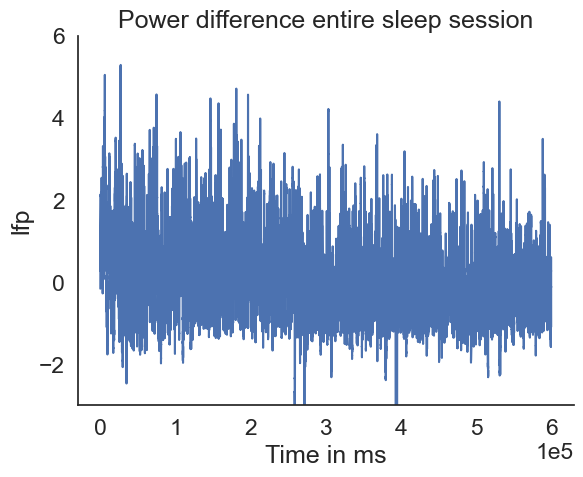

In [12]:
# Compute and plot power difference 
diff = zscored_power_theta - zscored_power_delta

x = np.arange(0, 600133)
plt.plot(x, diff)
plt.title("Power difference entire sleep session")
plt.xlabel("Time in ms")
plt.ylim(-3, 6)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel("lfp")

In [14]:
# Compute REM and n_REM sleeping periods.
threshold = 0.2
sleep_state = np.where(diff >= threshold, 1, 0) # Gives an array which is value 1 for REM sleep and 0 for nREM sleep

rem_periods = [] # Indicates when the animal is in rem sleep
nrem_periods = [] 
current_state = sleep_state[0]
start_idx = 0

for i in range(1, len(sleep_state)):
    if sleep_state[i] != current_state:
        period = (start_idx, i - 1)
        if current_state == 1:
            rem_periods.append(period)
        else:
            nrem_periods.append(period)
        
        start_idx = i
        current_state = sleep_state[i]

period = (start_idx, len(sleep_state) - 1)
if current_state == 1:
    rem_periods.append(period)
else:
    nrem_periods.append(period)

In [15]:
def find_longest_period(periods):
    longest_period = periods[0]
    longest_duration = periods[0][1] - periods[0][0]

    for period in periods[1:]:
        duration = period[1] - period[0]
        if duration > longest_duration:
            longest_duration = duration
            longest_period = period

    return longest_period, longest_duration


longest_rem_period, longest_rem_duration = find_longest_period(rem_periods)
longest_nrem_period, longest_nrem_duration = find_longest_period(nrem_periods)

print(f"Longest REM sleep period: {longest_rem_period} with duration {longest_rem_duration} timepoints")
print(f"Longest nREM sleep period: {longest_nrem_period} with duration {longest_nrem_duration} timepoints")


Longest REM sleep period: (9880, 13662) with duration 3782 timepoints
Longest nREM sleep period: (485538, 488806) with duration 3268 timepoints


In [16]:
# Plot examples of REM vs nREM lfp signals
ripple_power = compute_ripple_power(sleep_lfp, sampling_rate, low_f = 1, high_f = 200)
zscored_ripple_power = zscore(ripple_power)
zscored_lfp = zscore(lfp)

Text(0, 0.5, 'lfp')

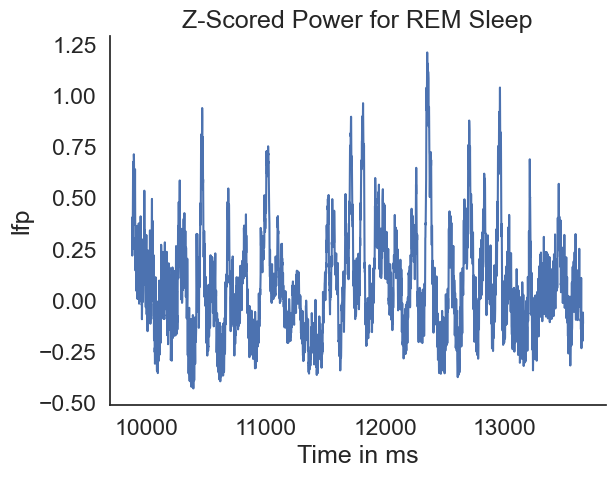

In [17]:
x_REM = np.arange(9880, 13662)
plt.plot(x_REM, zscored_ripple_power[9880:13662])
#plt.plot(x_REM, zscored_lfp[9880:13662])
plt.title("Z-Scored Power for REM Sleep")
plt.xlabel("Time in ms")
plt.ylabel("lfp")

Text(0, 0.5, 'lfp')

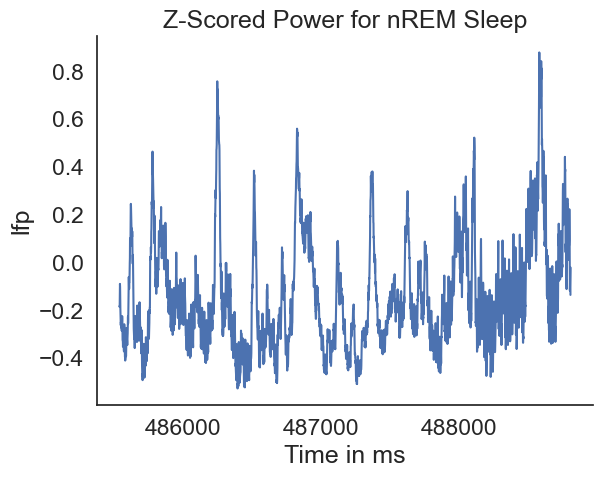

In [18]:
x_nREM = np.arange(485538, 488806)
plt.plot(x_nREM, zscored_ripple_power[485538:488806])
#plt.plot(x_nREM, zscored_lfp[485538:488806])
plt.title("Z-Scored Power for nREM Sleep")
plt.xlabel("Time in ms")
plt.ylabel("lfp")

In [19]:
# Explore how changing the threshold affects the amount of REM sleep detected.

threshold_list = np.arange(0, 1, 0.1)

for i in threshold_list:
    sleep_state = np.where(diff >= i, 1, 0)
    REM_number = np.unique(sleep_state, return_counts = True)
    print("The amount of time samples during REM sleep, with threshold = {0}, is {1}" .format(i, REM_number[1][1]))
    

The amount of time samples during REM sleep, with threshold = 0.0, is 272911
The amount of time samples during REM sleep, with threshold = 0.1, is 251435
The amount of time samples during REM sleep, with threshold = 0.2, is 230878
The amount of time samples during REM sleep, with threshold = 0.30000000000000004, is 211902
The amount of time samples during REM sleep, with threshold = 0.4, is 193351
The amount of time samples during REM sleep, with threshold = 0.5, is 176215
The amount of time samples during REM sleep, with threshold = 0.6000000000000001, is 159623
The amount of time samples during REM sleep, with threshold = 0.7000000000000001, is 143689
The amount of time samples during REM sleep, with threshold = 0.8, is 129299
The amount of time samples during REM sleep, with threshold = 0.9, is 115701


We see a descreasing amount of time samples with an increasing threshold. This makes sense since there will overall be less points in time with a larger difference in power. Therefore we see less REM sleep.

### FPB Comments 

Code is very well done. We should have suggested that you apply smoothing on the diff statistics before thresholding in order to see the longer periods of REM and NREM. We will change the assignment for next year. Grade: 9